## Sleep Diary Analysis

1/14/2021: Cleaning continues. As this stands, do not have proper date format for times collected from qualtrics participants. Also losing activity variables due to all NA. Not sure whether to do with the workaround to get correct times from redcap merge or whether this was happening without that step. Will revisit later.

In [37]:
import numpy as np
import pandas as pd
import os
import datetime as dt

dataDir = '/Users/mcmahonmc/Box/CogNeuroLab/Wearables/data/'
df = pd.read_csv(dataDir + 'sleep_diaries/qualtrics+redcap.csv', parse_dates = ['session1_date'])
redcap = pd.read_csv(dataDir + 'redcap_backup/WearableAssessment_DATA_2022-01-12_1550.csv')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,25,28,49,51,52,66,84,86,133,138,140,146,147,148,150,156,157,158,166,167,168,170,177,180,184,185,186,187,190,199,201,204,205,206,207,210,211,212,213,214,215,216,218,220,230,232,233,302,303,304,305,308,309,310,311,312,314,328,334,335,339,340,347,353,423,426,428,429,436,460,462,463,465,466,467,469,471,473,493) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
redcap['age_group'] = redcap.groupby('record_id')['age_group'].ffill()
redcap['age_group']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2605    NaN
2606    NaN
2607    NaN
2608    NaN
2609    NaN
Name: age_group, Length: 2610, dtype: float64

In [39]:
redcap[(redcap['redcap_event_name'] == 'online_eligibility_arm_1') & (redcap['age_group'] > 1) ][['record_id', 'age_group']].dropna()

,record_id,age_group
287,73,2.0
290,76,2.0
324,95,2.0
332,103,2.0
349,104,2.0
...,...,...
1329,238,3.0
2310,305,3.0
2375,308,3.0
2547,322,3.0


In [40]:
df = pd.merge(df, redcap[['record_id', 'redcap_event_name', 'age_group']], on = ['record_id', 'redcap_event_name'], how='outer')
df.drop('age_group_x', axis=1, inplace=True)
df.rename(columns = {'age_group_y': 'age_group'}, inplace=True)
df = df[~df['age_group'].isna()]

In [41]:
df.record_id = df.record_id.astype(str)
df = df[~df['record_id'].str.contains('TEST', na = False)] 

In [42]:
df.record_id = df.record_id.astype(float)
df.record_id = df.record_id.astype(int).astype(str)

In [43]:
df['record_id'] = df['record_id'].fillna(df['Subject'])
df = df[~df['record_id'].isna()]
df['record_id'] = df['record_id'].astype(str).apply(lambda x: x.split('.')[0].zfill(4))
df['record_id'] = df['age_group'].astype(int).astype(str) + df['record_id']

In [44]:
print(df.shape)
print(df['redcap_event_name'].unique())

(2567, 352)
['online_eligibility_arm_1' 'session_1_arm_1' 'day_1_arm_1' 'day_2_arm_1'
 'day_3_arm_1' 'day_4_arm_1' 'day_5_arm_1' 'day_6_arm_1' 'day_7_arm_1'
 'day_8_arm_1' 'day_9_arm_1' 'day_10_arm_1' 'day_11_arm_1' 'day_12_arm_1'
 'day_13_arm_1' 'session_2_arm_1' 'repeat_arm_1' 'day_14_arm_1'
 'day_15_arm_1' 'day_16_arm_1' 'day_17_arm_1' 'day_18_arm_1'
 'day_19_arm_1' 'day_20_arm_1' 'day_21_arm_1' 'day_22_arm_1'
 'day_23_arm_1' 'day_24_arm_1' 'day_25_arm_1' 'day_26_arm_1'
 'day_27_arm_1' 'session_3_sense_we_arm_1' 'day_28_arm_1' 'day_29_arm_1'
 'day_30_arm_1' 'day_31_arm_1']


In [45]:
df0 = df

tofill = df.loc[~df['redcap_event_name'].str.startswith('day', na=False)].index.to_list()
fillCols = df.loc[tofill].isna().all()[df.loc[tofill].isna().all() == False].index

df[fillCols] = df[fillCols].fillna(method='ffill')

df['COVID'] = np.where(df['session1_date'] <= dt.datetime.strptime('03/14/2020', '%m/%d/%Y'), 'Pre-COVID', 'COVID')

df = df.drop(['Subject', 'Unnamed: 0'], axis=1)

df = df.drop([col for col in df.columns if 'v2_sense' in col], axis=1)
# df = df.dropna(axis=1, how='all')

In [46]:
# df = pd.merge(df, redcap[['record_id', 'redcap_event_name'] + [col for col in redcap.columns if 'time' in col]], on=['record_id', 'redcap_event_name'], how='outer')
# df[[col for col in df.columns if 'time' in col]]
# df = df.drop([col for col in df.columns if 'v2_sense' in col], axis=1)
# df = df.dropna(axis=1, how='all')

# print(df.shape)

# timeCols = [col for col in df.columns if 'time' in col]
# for dupCol in [col for col in timeCols if col.endswith('_x') and df[col].dtype == np.float64 ]:
#     print(dupCol)
#     df[dupCol] = df[dupCol[:-1] + 'y']
#     df = df.drop([dupCol[:-1] + 'y'], axis=1)
    
#     print(df.shape)

# # df = df.drop([col for col in df.columns if col.endswith('_y')], axis=1)
# df.columns = df.columns.str.replace('_x', '')

In [47]:
# timeCols = [col for col in df.columns if '_time' in col]
# print(timeCols)

# for dupCol in [col for col in timeCols if df[col].dtype == np.float64 ]:
#     print(dupCol)
#     print(df[dupCol][~df[dupCol].isna()])
    
#     df = df.drop([dupCol], axis=1)

In [48]:
# df.columns = df.columns.str.replace('_x', '')
# df = df.drop([col for col in df.columns if col.endswith('_y')], axis=1)

In [49]:
timeCols = [col for col in df.columns if '_time' in col]

In [50]:
print(df.shape)
activityVars = sorted([col for col in df.columns if 'Which of the' in col])
activityVars[:3]

(2567, 351)


['Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Classmates or students',
 'Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Co-workers',
 'Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Family']

In [51]:
df.rename(columns = {'caffiene_v2': 'caffeine_v2',
                     'sleep_quality_f4be7b':'sleep_quality', 
                     'stress_a11e49':'stress',
                    'alcohol_59a121': 'alcohol',
                    'pittsburgh_sleep_quality_index_timestamp': 'psqi_timestamp'}, inplace = True)


In [52]:
diaryCols = df[df['redcap_event_name'].str.startswith('day', na=False)].dropna(axis=1, how='all').columns.to_list()
diaryCols

['surveyversion',
 'session1_date',
 'record_id',
 'redcap_event_name',
 'screening_questionnaire_timestamp',
 'gender',
 'psqi_timestamp',
 'global_psqi',
 'daily_sleep_survey_timestamp',
 'sleep_diary_date',
 'bed_time_0fbbb9',
 'sleep_time',
 'wakeup_time',
 'sleep_minutes',
 'wakeups',
 'awakening1_time',
 'awakening1_length',
 'awakening2_time',
 'awakening2_length',
 'awakening3_time',
 'awakening3_length',
 'awakening4_time',
 'awakening4_length',
 'awakening5_time',
 'awakening5_length',
 'awakening6_time',
 'awakening6_length',
 'awakening7_length',
 'sleep_quality',
 'watch_offs',
 'sleep_comments',
 'alcohol',
 'alcoholic_drinks',
 'caffeine',
 'caffeinated_drinks',
 'sleeping_pill',
 'sleeping_pill_name',
 'additional_meds',
 'additional_med_name1',
 'additional_med_name2',
 'additional_med_name3',
 'sad',
 'happy',
 'stress',
 'ruminate',
 'activity',
 'Place_Bar_party',
 'Place_Cafe_restaurant',
 'Place_Campus',
 'Place_Club_organization',
 "Place_Friend's_house",
 'Place

In [53]:
[c for c in df.columns if 'stress' in c]

['stress',
 'stress_v2',
 'Please use the following scale to answer the question about your mood yesterday. - How stressed did you feel yesterday?']

In [54]:
for v2Col in [c for c in df.columns if '_v2' in c and c[:-3] in df.columns]:
    print(v2Col[:-3])
    df[df['redcap_event_name'].str.startswith('day')][v2Col] = np.where(~df[df['redcap_event_name'].str.startswith('day')][v2Col[:-3]].isna(), np.nan, df[df['redcap_event_name'].str.startswith('day')][v2Col])

sleep_diary_date
sleep_time
sleep_minutes
wakeups
awakening1_time
awakening1_length


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


awakening2_time
awakening2_length
awakening3_time
awakening3_length
awakening4_time
awakening4_length
awakening5_time
awakening5_length
awakening6_time
awakening6_length
awakening7_time
awakening7_length
awakening8_time
awakening8_length
awakening9_time
awakening9_length
awakening10_time
awakening10_length
wakeup_time
sleep_quality
sleep_comments
alcohol
caffeine
sleeping_pill_name
additional_meds
additional_med_name1
sad
happy
stress
ruminate
activity
Place_Home
Place_Gym
Place_Library
Place_Outside
Place_Store_mall
Place_Other


In [55]:
print(df.shape)

for dupCol in [col for col in diaryCols if not col.endswith('_v2') and col + '_v2' in diaryCols]:
    print(dupCol)
    df[dupCol] = df.pop(dupCol).fillna(df.pop(dupCol + '_v2'))
    
    print(df.shape)

(2567, 351)
sleep_diary_date
(2567, 350)
sleep_time
(2567, 349)
wakeup_time
(2567, 348)
sleep_minutes
(2567, 347)
wakeups
(2567, 346)
awakening1_time
(2567, 345)
awakening1_length
(2567, 344)
awakening2_time
(2567, 343)
awakening2_length
(2567, 342)
awakening3_time
(2567, 341)
awakening3_length
(2567, 340)
awakening4_time
(2567, 339)
awakening4_length
(2567, 338)
sleep_quality
(2567, 337)
sleep_comments
(2567, 336)
alcohol
(2567, 335)
caffeine
(2567, 334)
additional_meds


/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/1868614738.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dupCol] = df.pop(dupCol).fillna(df.pop(dupCol + '_v2'))


(2567, 333)
additional_med_name1
(2567, 332)
sad
(2567, 331)
happy
(2567, 330)
stress
(2567, 329)
ruminate
(2567, 328)
activity
(2567, 327)
Place_Gym
(2567, 326)
Place_Home
(2567, 325)
Place_Library
(2567, 324)
Place_Outside
(2567, 323)
Place_Store_mall
(2567, 322)
Place_Other
(2567, 321)


In [56]:
df.rename(columns = {'bed_time':'bed_time_screening', 'bed_time_0fbbb9':'bed_time'}, inplace = True)

In [57]:
df.to_csv('/Users/mcmahonmc/Box/CogNeuroLab/Wearables/data/sleep_diaries/qualtrics+redcap_mm.csv', index=False)

In [58]:
activityVars = sorted([col for col in df.columns if 'Which of the' in col])
sleepVars = sorted([col for col in df.columns if 'sleep' in col or 'bed' in col or 'wake' in col or 'activity' in col])
moodVars = sorted([col for col in df.columns if 'happy' in col or 'sad' in col or 'stress' in col])
completeVars = sorted([col for col in df.columns if 'complete' in col])

In [59]:
# calculate tib and tst

df0 = df
# df = df0[['record_id', 'gender', 'caffeinated_drinks', 'alcohol'] + sleepVars + moodVars]

df['tib'] = np.where(
    pd.to_datetime(df['bed_time']).dt.hour < pd.to_datetime(df['wakeup_time']).dt.hour, 
    (pd.to_datetime(df['wakeup_time']) - pd.to_datetime(df['bed_time'])).dt.total_seconds() / 60,
    (pd.to_datetime(df['wakeup_time']) + pd.DateOffset(1) - pd.to_datetime(df['bed_time'])).dt.total_seconds() / 60)

df['tst'] = np.where(
    pd.to_datetime(df['sleep_time']).dt.hour < pd.to_datetime(df['wakeup_time']).dt.hour, 
    (pd.to_datetime(df['wakeup_time']) - pd.to_datetime(df['sleep_time'])).dt.total_seconds() / 60,
    (pd.to_datetime(df['wakeup_time']) + pd.DateOffset(1) - pd.to_datetime(df['sleep_time'])).dt.total_seconds() / 60)


sleepVars = sleepVars + ['tib', 'tst']

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/3779778958.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['tib'] = np.where(
/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/3779778958.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['tst'] = np.where(


In [60]:
df[sleepVars]

,Did you take any medication for sleep last night?,How long (in minutes) did it take you to fall asleep last night?,"How many hours did you do each of the following yesterday? - Exercising, physical activity, sports",How many hours did you do each of the following yesterday? - Spiritual or religious activity,How many times did you remove the activity band(s) yesterday?,How many times did you wake up during the night?,How well did you sleep last night?,Please list the time and duration of your awakening during the night. - How long (in minutes) were you awake? - Awakening #1 - Minutes,Please list the time and duration of your awakening during the night. - How long (in minutes) were you awake? - Awakening #2 - Minutes,Please list the time and duration of your awakening during the night. - How long (in minutes) were you awake? - Awakening #3 - Minutes,...,sleep_quality,sleep_time,sleeping_pill,sleeping_pill_name,sleeping_pill_name_v2,sleeping_pill_today_v2,wakeup_time,wakeups,tib,tst
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,74700.0,0.0,NaN,NaN,0.0,22200.0,5.0,1439.999999,1439.999999
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,81900.0,0.0,NaN,NaN,0.0,24900.0,4.0,1439.999999,1439.999999
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,80100.0,0.0,NaN,NaN,0.0,25800.0,2.0,1439.999999,1439.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df.to_csv('/Users/mcmahonmc/Box/CogNeuroLab/Wearables/data/sleep_diaries/sleepDiaries.csv', index=False)

In [62]:
df.columns

Index(['surveyversion', 'experimenter_1_timestamp', 'session1_date',
       'record_id', 'redcap_event_name', 'redcap_survey_identifier',
       'screening_questionnaire_timestamp', 'gender', 'psqi_timestamp',
       'global_psqi',
       ...
       'ruminate', 'activity', 'Place_Gym', 'Place_Home', 'Place_Library',
       'Place_Outside', 'Place_Store_mall', 'Place_Other', 'tib', 'tst'],
      dtype='object', length=323)

In [63]:
df[['record_id'] + activityVars]

,record_id,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Classmates or students,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Co-workers,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Family,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Friends,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - No one,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Others,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Roommates,Which of the following people did you interact with face-to-face (not video chat or on the phone) yesterday? - Significant other,"Which of the following people did you interact with on the phone (call, text, video call) or online (direct message, video chat, etc.) yesterday? - Classmates or students",...,Which of the following places did you spend time yesterday? Select all that apply. - Other,Which of the following places did you spend time yesterday? Select all that apply. - Outdoors,Which of the following places did you spend time yesterday? Select all that apply. - Pharmacy,Which of the following places did you spend time yesterday? Select all that apply. - Religious facility,Which of the following places did you spend time yesterday? Select all that apply. - Restaurant or cafe,Which of the following places did you spend time yesterday? Select all that apply. - School,"Which of the following places did you spend time yesterday? Select all that apply. - Store, mall",Which of the following places did you spend time yesterday? Select all that apply. - Vehicle (personal),"Which of the following places did you spend time yesterday? Select all that apply. - Vehicle (public transportation, rideshare)",Which of the following places did you spend time yesterday? Select all that apply. - Work (non-remote)
0,10011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,10326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2752,10326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2754,10328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2756,10330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Rest-activity measures

In [64]:
from pathlib import Path
import re

home_dir = str(Path.home())
data_dir = os.path.join(home_dir, 'Box/CogNeuroLab/Wearables/data/')
results_dir = '/Volumes/schnyer/Megan/Wearables/results/'
# data_dir = '/Volumes/schnyer/Megan/Wearables/data/'

# cr_act = pd.read_csv(data_dir + 'actiwatch/cr_act.csv')
# cr_fit = pd.read_csv(data_dir + 'fitbit/cr_fit.csv')

cr = pd.read_csv(results_dir + 'cr_cosinor_df.csv').dropna()
npar = pd.read_csv(results_dir + 'cr_nonpar_df.csv').dropna()

cr['subject'] = [re.findall("\d+", sub)[0] for sub in cr['Unnamed: 0']]
cr.drop(['Unnamed: 0'], axis=1, inplace=True)

drop_subs = [10148, 20103, 20184]
npar = npar[~npar['subject'].isin(drop_subs)]
cr = cr[~cr['subject'].isin(drop_subs)]
npar['subject'] = npar['subject'].astype(str)

In [65]:
df2 = cr.pivot_table(index='subject', columns='device')
df2.columns = ['{}_{}'.format(x,y) for x,y in df2.columns]

In [66]:
df2n = npar.pivot_table(index='subject', columns='device')
df2n.columns = ['{}_{}'.format(x,y) for x,y in df2n.columns]

In [67]:
df_ = pd.merge(df, df2.reset_index(), left_on='record_id', right_on='subject', how='outer')
df_ = pd.merge(df_, df2n.reset_index(), left_on='record_id', right_on='subject', how='outer')

In [68]:
len(df_.dropna(subset=['IV_Fitbit'])['record_id'].unique())

44

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
df_m = df_.groupby('record_id').mean().dropna(how='all', axis=1)
df_m

,gender,global_psqi,bed_time,awakening5_time,awakening5_length,awakening6_time,awakening6_length,awakening7_length,alcoholic_drinks,caffeinated_drinks,...,IS_Actiwatch,IS_Fitbit,IV_Actiwatch,IV_Fitbit,L5_Actiwatch,L5_Fitbit,M10_Actiwatch,M10_Fitbit,RA_Actiwatch,RA_Fitbit
record_id,,,,,,,,,,,,,,,,,,,,,
10011,2.0,1.117647,79943.076923,18900.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.075909,0.210442,2.167133,0.164206,0.002991,0.000261,0.059239,0.094548,0.903862,0.994501
10012,2.0,2.000000,17014.285714,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,...,0.075122,0.238561,2.082229,0.076745,0.000652,0.000522,0.021110,0.102290,0.940046,0.989852
10013,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,2.0,6.000000,51550.000000,NaN,NaN,NaN,NaN,NaN,2.000000,1.0,...,0.098643,0.318342,2.176645,0.107596,0.002044,0.000233,0.062699,0.104364,0.936865,0.995553
10016,2.0,5.000000,59785.714286,NaN,NaN,NaN,NaN,NaN,5.714286,1.0,...,0.076437,0.191609,2.130655,0.082882,0.001762,0.000937,0.027080,0.081403,0.877794,0.977252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30238,1.0,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30305,1.0,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30308,1.0,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


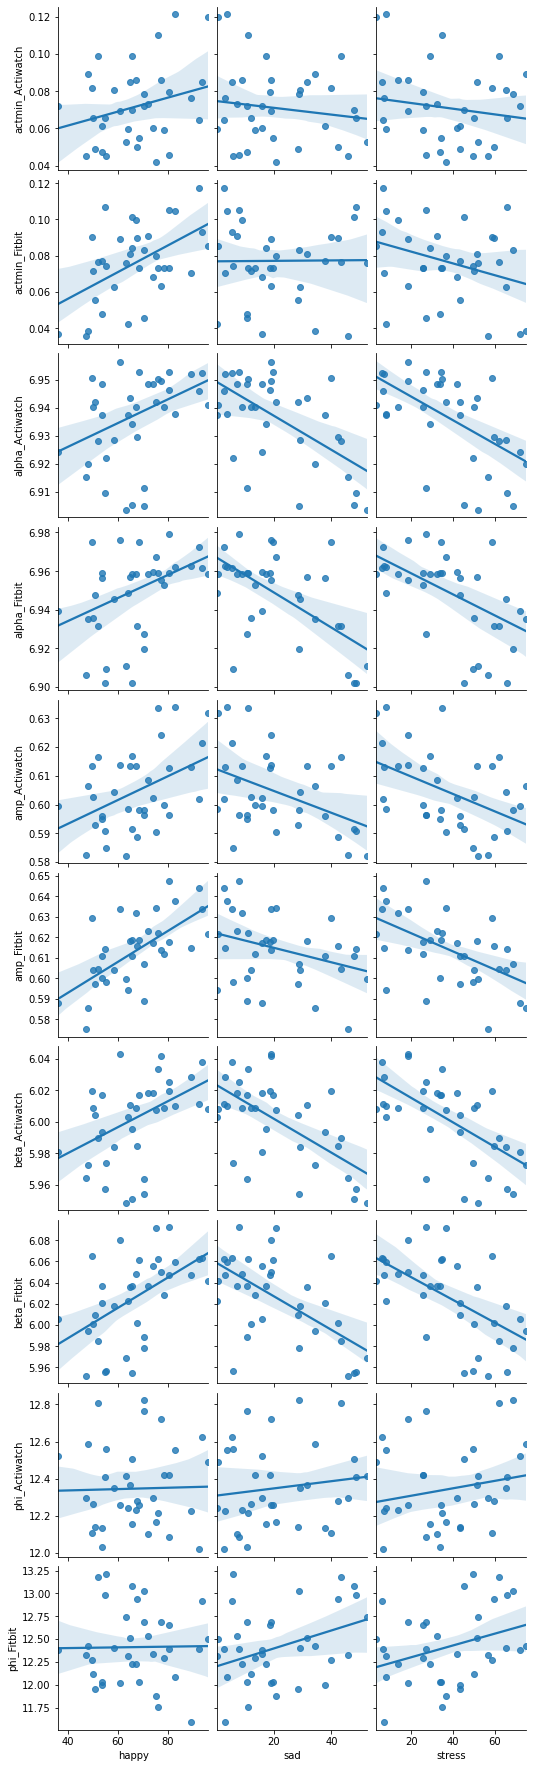

In [74]:
sns.pairplot(data=df_m, 
             x_vars=['happy', 'sad', 'stress', 'ruminate'], 
             y_vars=df2.columns,
            kind='reg', plot_kws=dict(robust=True,n_boot=50))

In [184]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [223]:
df_m[['happy', 'sad', 'stress', 'ruminate']]

,happy,sad,stress,ruminate
record_id,,,,
10011,96.384615,0.692308,3.076923,0.153846
10012,55.142857,5.857143,49.500000,0.000000
10013,NaN,NaN,NaN,NaN
10014,52.000000,43.416667,61.916667,51.916667
10016,53.857143,37.785714,43.214286,4.571429
...,...,...,...,...
30238,NaN,NaN,NaN,NaN
30305,NaN,NaN,NaN,NaN
30308,NaN,NaN,NaN,NaN


In [257]:
import pingouin as pg

corr = pg.pairwise_corr(data=df_m, columns = list(df2.columns) + ['happy', 'sad', 'stress', 'ruminate'])
corr_a = corr[corr['X'].str.endswith('watch')]
corr_a = corr_a[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]

# corr_a = corr_a.style.format("{.3f"))
corr_a['sig'] = np.where(corr_a['p-unc'] < 0.05, '*', '')
corr_a['sig'] = np.where(corr_a['p-unc'] < 0.01, '**', corr_a['sig'])
corr_a['sig'] = np.where(corr_a['p-unc'] < 0.001, '***', corr_a['sig'])

corr_a['r_CI_p'] = corr_a['r'].map('{:.2f}'.format).astype(str) + ' ' + corr_a['CI95%'].astype(str) + ' ' + corr_a['sig']
corr_a = corr_a.pivot(index='X', columns='Y', values='r_CI_p')

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/1804599604.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr_a = corr_a[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]


In [255]:
corr_b = corr[corr['X'].str.endswith('bit')]
corr_b = corr_b[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]

# corr_b = corr_b.style.format("{.3f"))
corr_b['sig'] = np.where(corr_b['p-unc'] < 0.05, '*', '')
corr_b['sig'] = np.where(corr_b['p-unc'] < 0.01, '**', corr_b['sig'])
corr_b['sig'] = np.where(corr_b['p-unc'] < 0.001, '***', corr_b['sig'])

corr_b['r_CI_p'] = corr_b['r'].map('{:.2f}'.format).astype(str) + ' ' + corr_b['CI95%'].astype(str) + ' ' + corr_b['sig']
corr_b = corr_b.pivot(index='X', columns='Y', values='r_CI_p')

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/3181003734.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr_b = corr_b[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]


In [258]:
corr_a.round(3).to_latex('/Users/mcmahonmc/Desktop/corr_a_cosinor.tex', index=True)
corr_b.round(3).to_latex('/Users/mcmahonmc/Desktop/corr_b_cosinor.tex', index=True)

In [202]:
corr_a.style.background_gradient(cmap='coolwarm')

,happy,sad,stress,ruminate
actmin_Actiwatch,nan,nan,nan,nan
alpha_Actiwatch,0.388615,-0.568321,-0.573601,-0.380561
amp_Actiwatch,0.452082,-0.431849,-0.467419,nan
beta_Actiwatch,0.446629,-0.593428,-0.624743,-0.394048
phi_Actiwatch,nan,nan,nan,nan


In [203]:
corr_b.style.background_gradient(cmap='coolwarm')

,happy,sad,stress,ruminate
actmin_Fitbit,0.492895,nan,nan,nan
alpha_Fitbit,0.436367,-0.560159,-0.572518,-0.384897
amp_Fitbit,0.641384,-0.340287,-0.530492,nan
beta_Fitbit,0.527292,-0.559312,-0.598831,-0.384085
phi_Fitbit,nan,0.349819,0.332840,0.345771


In [206]:
(corr_a.reset_index(drop=True)- corr_b.reset_index(drop=True)).style.background_gradient(cmap='coolwarm')

,happy,sad,stress,ruminate
0,nan,nan,nan,nan
1,-0.047752,-0.008163,-0.001083,0.004336
2,-0.189301,-0.091562,0.063074,nan
3,-0.080663,-0.034115,-0.025912,-0.009963
4,nan,nan,nan,nan


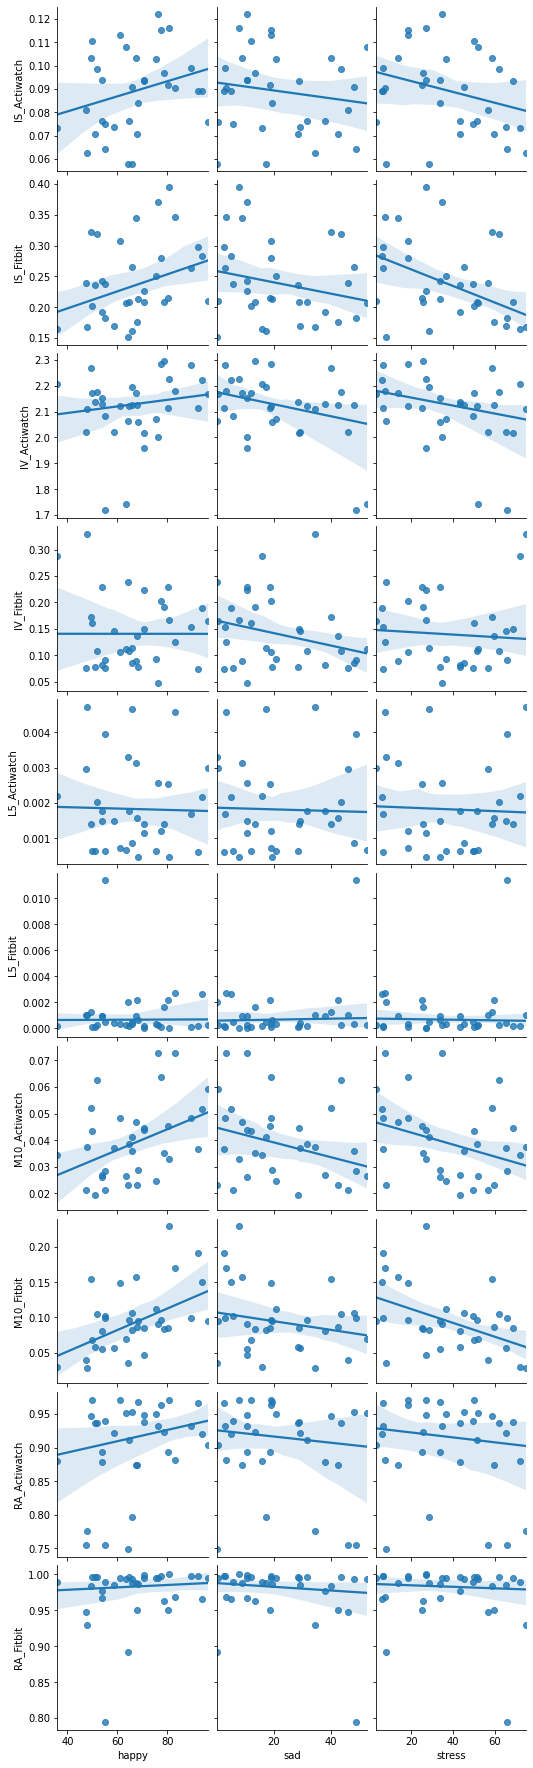

In [92]:
sns.pairplot(data=df_m, 
             x_vars=['happy', 'sad', 'stress', 'ruminate'], 
             y_vars=df2n.columns,
            kind='reg', plot_kws=dict(robust=True,n_boot=50))

In [259]:
import pingouin as pg

corr = pg.pairwise_corr(data=df_m, columns = list(df2n.columns) + ['happy', 'sad', 'stress', 'ruminate'])
corr_a = corr[corr['X'].str.endswith('watch')]
corr_a = corr_a[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]

# corr_a = corr_a.style.format("{.3f"))
corr_a['sig'] = np.where(corr_a['p-unc'] < 0.05, '*', '')
corr_a['sig'] = np.where(corr_a['p-unc'] < 0.01, '**', corr_a['sig'])
corr_a['sig'] = np.where(corr_a['p-unc'] < 0.001, '***', corr_a['sig'])

corr_a['r_CI_p'] = corr_a['r'].map('{:.2f}'.format).astype(str) + ' ' + corr_a['CI95%'].astype(str) + ' ' + corr_a['sig']
corr_a = corr_a.pivot(index='X', columns='Y', values='r_CI_p')

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/2800108574.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr_a = corr_a[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]


In [260]:
corr_b = corr[corr['X'].str.endswith('bit')]
corr_b = corr_b[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]

# corr_b = corr_b.style.format("{.3f"))
corr_b['sig'] = np.where(corr_b['p-unc'] < 0.05, '*', '')
corr_b['sig'] = np.where(corr_b['p-unc'] < 0.01, '**', corr_b['sig'])
corr_b['sig'] = np.where(corr_b['p-unc'] < 0.001, '***', corr_b['sig'])

corr_b['r_CI_p'] = corr_b['r'].map('{:.2f}'.format).astype(str) + ' ' + corr_b['CI95%'].astype(str) + ' ' + corr_b['sig']
corr_b = corr_b.pivot(index='X', columns='Y', values='r_CI_p')

/var/folders/ld/qzxjl7f92_5gzy756sfjkjfh0000gn/T/ipykernel_96193/3181003734.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr_b = corr_b[corr['Y'].isin(['happy', 'sad', 'stress', 'ruminate'])]


In [261]:
corr_a.round(3).to_latex('/Users/mcmahonmc/Desktop/corr_a_npar.tex', index=True)
corr_b.round(3).to_latex('/Users/mcmahonmc/Desktop/corr_b_npar.tex', index=True)

In [208]:
corr_a.style.background_gradient(cmap='coolwarm')

,happy,sad,stress,ruminate
IS_Actiwatch,nan,nan,nan,nan
IV_Actiwatch,nan,-0.438670,-0.357860,-0.429192
L5_Actiwatch,nan,nan,nan,nan
M10_Actiwatch,0.413326,nan,nan,nan
RA_Actiwatch,nan,nan,nan,nan


In [209]:
corr_b.style.background_gradient(cmap='coolwarm')

,happy,sad,stress,ruminate
IS_Fitbit,0.341019,nan,-0.379480,nan
IV_Fitbit,nan,nan,nan,nan
L5_Fitbit,nan,nan,nan,0.366803
M10_Fitbit,0.518779,nan,-0.446083,nan
RA_Fitbit,nan,nan,nan,-0.380724


In [210]:
(corr_a.reset_index(drop=True)- corr_b.reset_index(drop=True)).style.background_gradient(cmap='coolwarm')

,happy,sad,stress,ruminate
0,nan,nan,nan,nan
1,nan,nan,nan,nan
2,nan,nan,nan,nan
3,-0.105453,nan,nan,nan
4,nan,nan,nan,nan
